# Sentiment Analysis on Social Media Comments

## Introduction

This notebook details the steps taken to perform sentiment analysis on comments from social media platforms using Python. The goal is to identify trends and patterns in sentiment across different content and user interactions.


In addition to the original sentiment analysis using VADER, we will explore a binary classification approach using logistic regression to classify sentiment as positive or negative.

## Setup Environment

Ensure Python and the necessary libraries are installed. We will be using the following libraries:
- `pandas` for data manipulation
- `matplotlib` and `seaborn` for visualization
- `VADER` from `nltk` for sentiment analysis
- `scikit-learn` for building the predictive model.

In [12]:
pip install pandas nltk matplotlib seaborn scikit-learn wordcloud joblib ipywidgets # type: ignore


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: /home/estifanos/.asdf/installs/python/3.10.13/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Load and Prepare Your Dataset

Import the necessary libraries and load the dataset using pandas. We focus on columns relevant to our sentiment analysis.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Read the data set
data_url = "https://raw.githubusercontent.com/keitazoumana/VADER_sentiment-Analysis/main/data/testdata.manual.2009.06.14.csv"
df = pd.read_csv(data_url)

# Display the first few rows of the dataframe
df.head()

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...


## Data Cleaning

Ensure data types are appropriate, handle missing values, and remove duplicates.

In [14]:
def format_data(data):

    last_col = str(data.columns[-1])
    first_col = str(data.columns[0])

    data.rename(columns = {last_col: 'tweet_text', first_col: 'polarity'}, inplace=True) 

    # Change 0, 2, 4 to negative, neutral and positive
    labels = {0: 'negative', 2: 'neutral', 4: 'positive'}
    data['polarity'] = data['polarity'].map(labels)

    # Get only the two columns
    return data[['tweet_text', 'polarity']]

df = format_data(df)

## Perform Sentiment Analysis

Set up and apply the VADER sentiment analysis tool from nltk to the transcription text of the videos.

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def format_output(output_dict):
    
    polarity = "neutral"

    if(output_dict['compound']>= 0.05):
        polarity = "positive"

    elif(output_dict['compound']<= -0.05):
        polarity = "negative"

    return polarity

def predict_sentiment(text):
  
    output_dict =  sia.polarity_scores(text)
    return format_output(output_dict)

df["vader_prediction"] = df["tweet_text"].apply(predict_sentiment)
df.sample(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/estifanos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,tweet_text,polarity,vader_prediction
122,VIRAL MARKETING FAIL. This Acia Pills brand ou...,negative,negative
411,First dentist appointment [in years] on Wednes...,neutral,neutral
266,ok.. do nothing.. just thinking about 40D,neutral,neutral
73,"By the way, I'm totally inspired by this freak...",positive,positive
253,Watching Lebron highlights. Damn that niggas good,positive,negative


## Visualization of Sentiment Distribution

### Sentiment Distribution per Verification Status

Visualize the sentiment distribution based on the binary classification model.

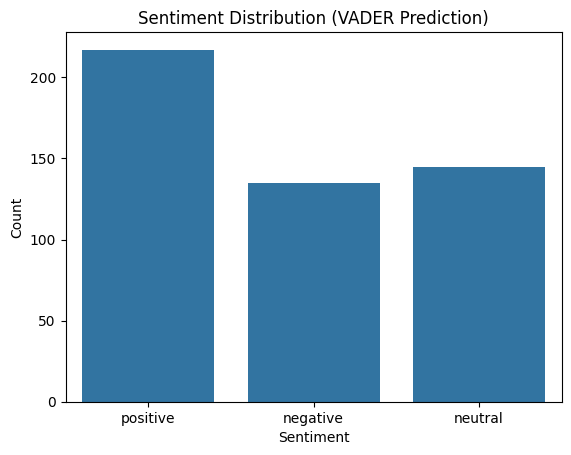

In [16]:
sns.countplot(x='vader_prediction', data=df)
plt.title('Sentiment Distribution (VADER Prediction)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


## VADER Performance on the Dataset

From the original polarity column and VADER's prediction we can generate the confusion matrix and its overall performance (precision, recall, and f1 score).

Accuracy: 0.716297786720322

              precision    recall  f1-score   support

    negative       0.84      0.64      0.72       177
     neutral       0.67      0.70      0.68       139
    positive       0.67      0.81      0.73       181

    accuracy                           0.72       497
   macro avg       0.73      0.71      0.71       497
weighted avg       0.73      0.72      0.72       497



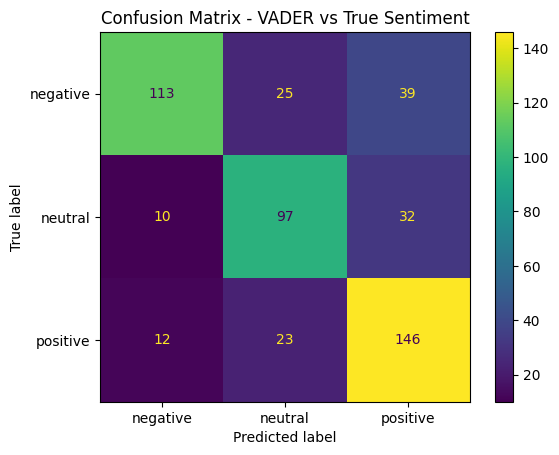

In [17]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

accuracy = accuracy_score(df['polarity'], df['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(df['polarity'], df['vader_prediction']))

# Plot Confusion Matrix
ConfusionMatrixDisplay.from_predictions(df['polarity'], df['vader_prediction'])
plt.title('Confusion Matrix - VADER vs True Sentiment')
plt.show()

Logistic Regression Accuracy: 0.71
ROC AUC Score: 0.618421052631579


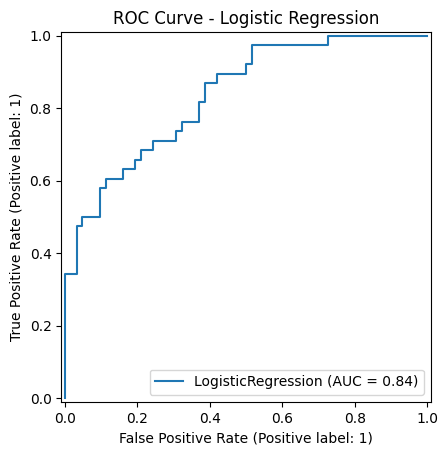

Model and vectorizer saved successfully.


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Vectorize text data
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['tweet_text'])
y = df['polarity'].apply(lambda x: 1 if x == 'positive' else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print("Logistic Regression Accuracy: {}".format(accuracy))
print("ROC AUC Score: {}".format(roc_auc))

# Plot ROC curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()


# Save the trained logistic regression model and the vectorizer for future use.
import joblib

# Save the model and vectorizer
joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

print("Model and vectorizer saved successfully.")

In [19]:
import ipywidgets as widgets
import joblib

# Load the trained logistic regression model and vectorizer
model = joblib.load('logistic_regression_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Function to predict sentiment using VADER
def predict_vader_sentiment(text):
    output_dict = sia.polarity_scores(text)
    compound = output_dict['compound']
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Function to predict sentiment using Logistic Regression
def predict_logistic_sentiment(text):
    X = vectorizer.transform([text])
    prediction = model.predict(X)
    return "Positive" if prediction == 1 else "Negative"

# UI Elements
text_input = widgets.Textarea(
    value='',
    placeholder='Type something here...',
    description='Input Text:',
    disabled=False
)

vader_button = widgets.Button(
    description='Analyze with VADER',
    disabled=False,
    button_style='', 
    tooltip='Click to analyze sentiment using VADER',
    icon='check'
)

logistic_button = widgets.Button(
    description='Analyze with Logistic Regression',
    disabled=False,
    button_style='', 
    tooltip='Click to analyze sentiment using Logistic Regression',
    icon='check'
)

output_vader = widgets.Output()
output_logistic = widgets.Output()

# Event handlers for buttons
def on_vader_button_clicked(b):
    with output_vader:
        output_vader.clear_output()
        if text_input.value:
            vader_result = predict_vader_sentiment(text_input.value)
            display(f"VADER Sentiment: **{vader_result}**")
        else:
            display("Please enter some text to analyze.")

def on_logistic_button_clicked(b):
    with output_logistic:
        output_logistic.clear_output()
        if text_input.value:
            logistic_result = predict_logistic_sentiment(text_input.value)
            display(f"Logistic Regression Sentiment: **{logistic_result}**")
        else:
            display("Please enter some text to analyze.")

# Bind the event handlers to the buttons
vader_button.on_click(on_vader_button_clicked)
logistic_button.on_click(on_logistic_button_clicked)

# Display the UI elements
display(text_input, vader_button, output_vader, logistic_button, output_logistic)

Textarea(value='', description='Input Text:', placeholder='Type something here...')

Button(description='Analyze with VADER', icon='check', style=ButtonStyle(), tooltip='Click to analyze sentimen…

Output()

Button(description='Analyze with Logistic Regression', icon='check', style=ButtonStyle(), tooltip='Click to an…

Output()